In [3]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import optuna


In [4]:
df = pd.read_csv('heart.csv')
print(df.dtypes)
df.head()


age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
X = df.drop('output', axis=1)
y = pd.DataFrame(df['output'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

sample_row = X.iloc[0, :].to_dict()

In [6]:
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(f'score: {accuracy_score(y_valid, preds)}')

score: 0.8021978021978022


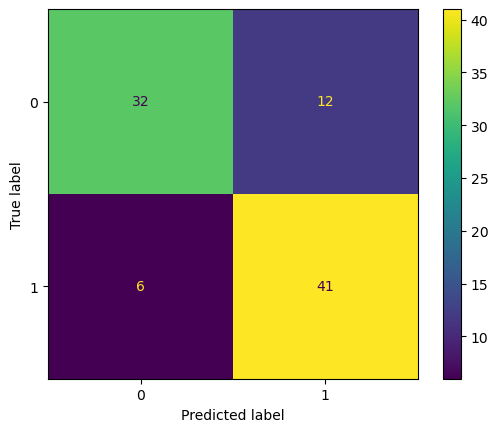

In [7]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

# Optuna

In [24]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    clf = XGBClassifier(n_estimators=n_estimators, booster=booster, random_state=0)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

model_params_list = ['n_estimators', 'booster']
model_params = dict()
model_params['random_state'] = 0

for key, value in study.best_trial.params.items():
    if key in model_params_list:
        model_params[key] = value

model = XGBClassifier(**model_params)
model.fit(X_train, y_train)

[I 2024-10-11 13:28:54,341] A new study created in memory with name: no-name-16f79a25-ccba-4336-bc43-f418244a4430
[I 2024-10-11 13:28:54,746] Trial 0 finished with value: 0.8021978021978022 and parameters: {'n_estimators': 56, 'booster': 'dart'}. Best is trial 0 with value: 0.8021978021978022.
[I 2024-10-11 13:28:54,814] Trial 1 finished with value: 0.8021978021978022 and parameters: {'n_estimators': 115, 'booster': 'gbtree'}. Best is trial 0 with value: 0.8021978021978022.
[I 2024-10-11 13:28:54,923] Trial 2 finished with value: 0.8131868131868132 and parameters: {'n_estimators': 252, 'booster': 'gbtree'}. Best is trial 2 with value: 0.8131868131868132.
[I 2024-10-11 13:28:55,517] Trial 3 finished with value: 0.8021978021978022 and parameters: {'n_estimators': 105, 'booster': 'dart'}. Best is trial 2 with value: 0.8131868131868132.
[I 2024-10-11 13:28:57,596] Trial 4 finished with value: 0.8131868131868132 and parameters: {'n_estimators': 223, 'booster': 'dart'}. Best is trial 2 with 

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=252, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [25]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [26]:
from pydantic import BaseModel, ValidationError

class Symptoms(BaseModel):
    age: int
    sex: int
    cp: int
    trtbps: int
    chol: int
    fbs: int
    restecg: int
    thalachh: int
    exng: int
    oldpeak: float
    slp: int
    caa: int
    thall: int

with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print(sample_row)
symptoms = Symptoms(**sample_row)
inputs = pd.DataFrame([symptoms.model_dump()])
pred = loaded_model.predict(inputs)[0]
pred

{'age': 63.0, 'sex': 1.0, 'cp': 3.0, 'trtbps': 145.0, 'chol': 233.0, 'fbs': 1.0, 'restecg': 0.0, 'thalachh': 150.0, 'exng': 0.0, 'oldpeak': 2.3, 'slp': 0.0, 'caa': 0.0, 'thall': 1.0}


1

In [27]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        symptoms = Symptoms(**request.json)
        inputs = np.array(list(symptoms.model_dump().values())).reshape(1,-1)
        pred = loaded_model.predict(inputs)[0]
        response = {
            'prediction': int(pred)
        }

        return jsonify(response), 200

    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 13:29:22] "POST /predict HTTP/1.1" 200 -
